<a href="https://colab.research.google.com/github/imraunav/Computer-vision-EE511/blob/main/cv-AlexNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import random_split
from tqdm import tqdm

In [2]:
# Download training data from open datasets.
train_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform= transforms.Compose([
    transforms.Resize(64),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
]),
)

# Download test data from open datasets.
test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
]),
)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_dataloader=DataLoader(test_data,batch_size=batch_size*2, num_workers=2, pin_memory=True)

for X, y in train_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 3, 64, 64])
Shape of y: torch.Size([64]) torch.int64


In [4]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [20]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet')#, weights='AlexNet_Weights.IMAGENET1K_V1'

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [21]:
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [22]:
# for param in model.features.parameters():
#     param.requires_grad = False

In [23]:
model.classifier[6] = nn.Linear(4096, 10)

In [24]:
for param in model.parameters():
    print(param.requires_grad)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [25]:
# model.classifier[6].requires_grad = True

In [26]:
# for block in model.features.parameters():
#   print(block, block.requires_grad)

In [27]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    batch_losses = []
    for batch in tqdm(dataloader):
        X, y = batch
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = nn.functional.log_softmax(model(X), dim=-1)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_losses.append(loss.item())

    return sum(batch_losses)/len(batch_losses)

In [28]:
model.to(device)
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [29]:
# sample = next(iter(train_dataloader))
# img = sample[0]
# print(img.shape)

# # features = model.features(img.unsqueeze(0).to(device))
# # print(features.shape)
# nn.functional.softmax(model(img.to(device)), dim=-1)

In [30]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [31]:
max_epoch = 25

train_loss = []
for epoch in range(max_epoch):
  print(f"Epoch {epoch+1}")
  epoch_loss = train(train_dataloader,model,loss_fn,optimizer)
  print(f"Train loss: {epoch_loss}")
  train_loss.append(epoch_loss)

Epoch 1


100%|██████████| 782/782 [00:31<00:00, 24.71it/s]


Train loss: 1.849983209081928
Epoch 2


100%|██████████| 782/782 [00:32<00:00, 24.40it/s]


Train loss: 1.5209619291603107
Epoch 3


100%|██████████| 782/782 [00:31<00:00, 24.54it/s]


Train loss: 1.3873690692207696
Epoch 4


100%|██████████| 782/782 [00:31<00:00, 24.45it/s]


Train loss: 1.3097036561697646
Epoch 5


100%|██████████| 782/782 [00:31<00:00, 24.55it/s]


Train loss: 1.2531712677930018
Epoch 6


100%|██████████| 782/782 [00:32<00:00, 24.02it/s]


Train loss: 1.2123319184231331
Epoch 7


100%|██████████| 782/782 [00:32<00:00, 23.70it/s]


Train loss: 1.17021981278039
Epoch 8


100%|██████████| 782/782 [00:32<00:00, 24.10it/s]


Train loss: 1.1437788719258954
Epoch 9


100%|██████████| 782/782 [00:31<00:00, 24.62it/s]


Train loss: 1.125124332773716
Epoch 10


100%|██████████| 782/782 [00:32<00:00, 24.42it/s]


Train loss: 1.096801583648033
Epoch 11


100%|██████████| 782/782 [00:32<00:00, 24.32it/s]


Train loss: 1.0772850501262927
Epoch 12


100%|██████████| 782/782 [00:32<00:00, 24.01it/s]


Train loss: 1.0681913293078733
Epoch 13


100%|██████████| 782/782 [00:32<00:00, 24.39it/s]


Train loss: 1.0602218974429323
Epoch 14


100%|██████████| 782/782 [00:33<00:00, 23.26it/s]


Train loss: 1.0447622464440973
Epoch 15


100%|██████████| 782/782 [00:32<00:00, 23.95it/s]


Train loss: 1.0325476143061352
Epoch 16


100%|██████████| 782/782 [00:32<00:00, 24.43it/s]


Train loss: 1.0262059646341808
Epoch 17


100%|██████████| 782/782 [00:32<00:00, 24.08it/s]


Train loss: 1.014129627924746
Epoch 18


100%|██████████| 782/782 [00:31<00:00, 24.45it/s]


Train loss: 1.0081181031511264
Epoch 19


100%|██████████| 782/782 [00:32<00:00, 24.34it/s]


Train loss: 1.002418359374756
Epoch 20


100%|██████████| 782/782 [00:32<00:00, 24.38it/s]


Train loss: 0.9944230195354012
Epoch 21


100%|██████████| 782/782 [00:33<00:00, 23.66it/s]


Train loss: 0.9875147725310167
Epoch 22


100%|██████████| 782/782 [00:32<00:00, 23.82it/s]


Train loss: 0.981186183974566
Epoch 23


100%|██████████| 782/782 [00:32<00:00, 24.41it/s]


Train loss: 0.9724334084316898
Epoch 24


100%|██████████| 782/782 [00:31<00:00, 24.65it/s]


Train loss: 0.9715545441564697
Epoch 25


100%|██████████| 782/782 [00:31<00:00, 24.52it/s]

Train loss: 0.9650742100632709


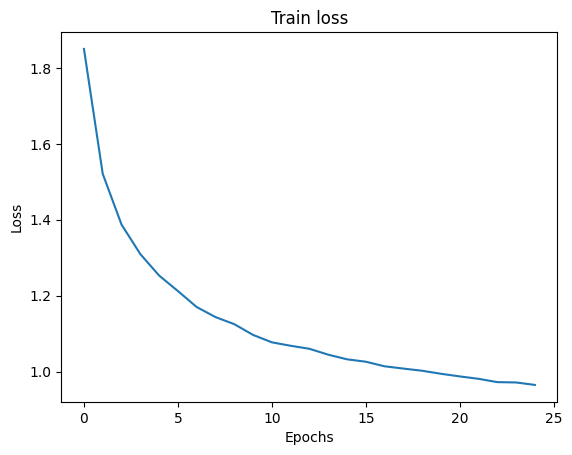

In [32]:
import matplotlib.pyplot as plt

plt.plot(train_loss)
plt.title("Train loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [33]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [34]:
test(test_dataloader,model,loss_fn)

Test Error: 
 Accuracy: 62.9%, Avg loss: 1.094069 

